# load the model 

In [101]:


from transformers import AutoModelForObjectDetection
model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")

In [102]:
model.config.id2label

{0: 'table', 1: 'table rotated'}

## if available, move th model to GPU for faster predictions

In [134]:
import torch

torch.set_default_dtype(torch.float32)

# Explicitly disable CUDA in case it’s slowing CPU operations
device = torch.device("cuda" if torch.mps.is_available() else "cpu")

model.to(device)
print(device)

cpu


In [105]:
model = AutoModelForObjectDetection.from_pretrained(
    "microsoft/table-transformer-detection", revision="no_timm"
).to(device).eval()

In [135]:
import torch

torch.set_num_threads(4)  # Use all available cores
#torch.backends.mkldnn.enabled = True  # Use Intel MKL acceleration
torch.backends.openmp.enabled = True  # Use OpenMP for multi-threading

### load images - by now will be using just one image - but should be a iterative process of extraction

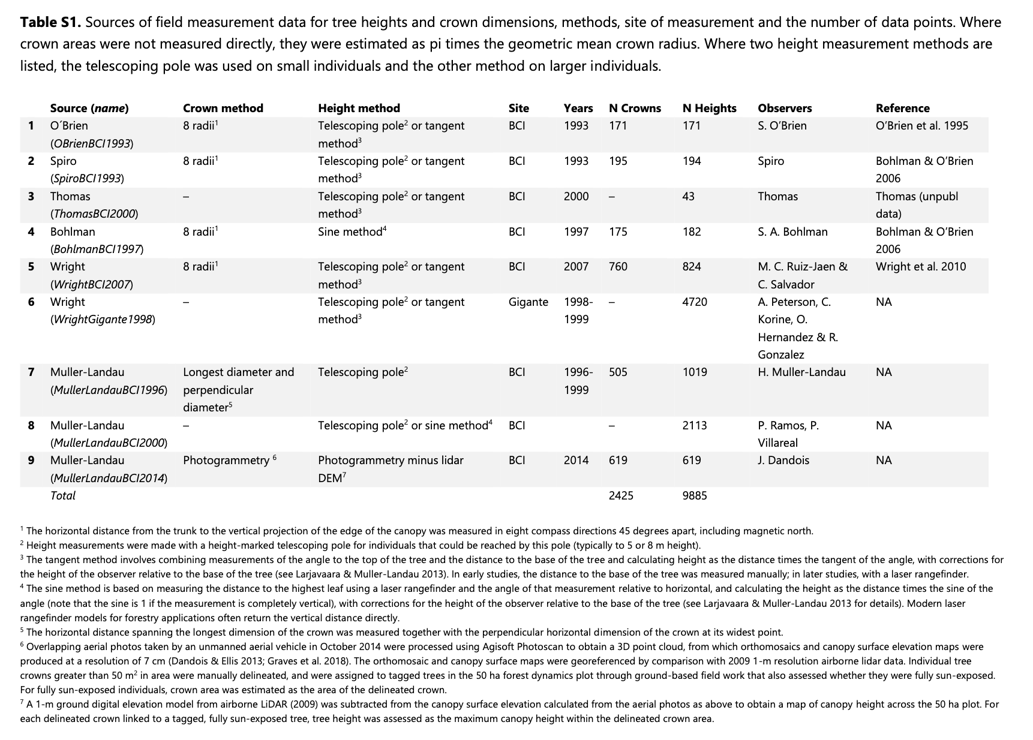

In [136]:
from PIL import Image

path = "/workspaces/backend-flask/cano_table_1_full.png"

image = Image.open(path).convert('RGB')

width, height = image.size

display(image.resize((int(0.6 * width), int(0.6 * height))))

### Image preparation for the model 

In [137]:
from torchvision import transforms

class MaxResize(object):
    def __init__(self, max_size):
        self.max_size = max_size

    def __call__(self, image: Image.Image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(width * scale), int(height * scale)))

        return resized_image

detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [138]:
pixel_values = detection_transform(image).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 573, 800])


In [139]:
import torch 

with torch.no_grad():
    scripted_model = torch.jit.trace(model, torch.rand(1, 3, 1200, 1200).to(device), strict=False)
    scripted_model.eval()

with torch.no_grad():
    outputs = model(pixel_values)

/home/vscode/.local/lib/python3.12/site-packages/transformers/models/resnet/modeling_resnet.py:91: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
/home/vscode/.local/lib/python3.12/site-packages/transformers/models/table_transformer/modeling_table_transformer.py:507: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (batch_size * self.num_heads, target_len, source_len):
/home/vscode/.local/lib/python3.12/site-packages/transformers/models/table_transformer/modeling_table_transformer.py:514: Trac

In [114]:
scripted_model

TableTransformerForObjectDetection(
  original_name=TableTransformerForObjectDetection
  (model): TableTransformerModel(
    original_name=TableTransformerModel
    (backbone): TableTransformerConvModel(
      original_name=TableTransformerConvModel
      (conv_encoder): TableTransformerConvEncoder(
        original_name=TableTransformerConvEncoder
        (model): ResNetBackbone(
          original_name=ResNetBackbone
          (embedder): ResNetEmbeddings(
            original_name=ResNetEmbeddings
            (embedder): ResNetConvLayer(
              original_name=ResNetConvLayer
              (convolution): Conv2d(original_name=Conv2d)
              (normalization): TableTransformerFrozenBatchNorm2d(original_name=TableTransformerFrozenBatchNorm2d)
              (activation): ReLU(original_name=ReLU)
            )
            (pooler): MaxPool2d(original_name=MaxPool2d)
          )
          (encoder): ResNetEncoder(
            original_name=ResNetEncoder
            (stages): Mod

In [140]:
outputs.logits.shape

torch.Size([1, 15, 3])

In [141]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"

def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

In [142]:
objects = outputs_to_objects(outputs, image.size, id2label)

In [143]:
print(objects)

[{'label': 'table', 'score': 0.9999499320983887, 'bbox': [47.15049743652344, 164.14547729492188, 1623.47802734375, 825.27099609375]}]


In [144]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def visualize_detected_tables(img, det_tables, out_path=None):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()

    for det_table in det_tables:
        bbox = det_table['bbox']

        if det_table['label'] == 'table':
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        elif det_table['label'] == 'table rotated':
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        else:
            continue

        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor='none',facecolor=facecolor, alpha=0.1)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', alpha=alpha)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=0,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', hatch=hatch, alpha=0.2)
        ax.add_patch(rect)

    plt.xticks([], [])
    plt.yticks([], [])

    legend_elements = [Patch(facecolor=(1, 0, 0.45), edgecolor=(1, 0, 0.45),
                                label='Table', hatch='//////', alpha=0.3),
                        Patch(facecolor=(0.95, 0.6, 0.1), edgecolor=(0.95, 0.6, 0.1),
                                label='Table (rotated)', hatch='//////', alpha=0.3)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.02), loc='upper center', borderaxespad=0,
                    fontsize=10, ncol=2)
    plt.gcf().set_size_inches(10, 10)
    plt.axis('off')

    if out_path is not None:
      plt.savefig(out_path, bbox_inches='tight', dpi=150)

    return fig

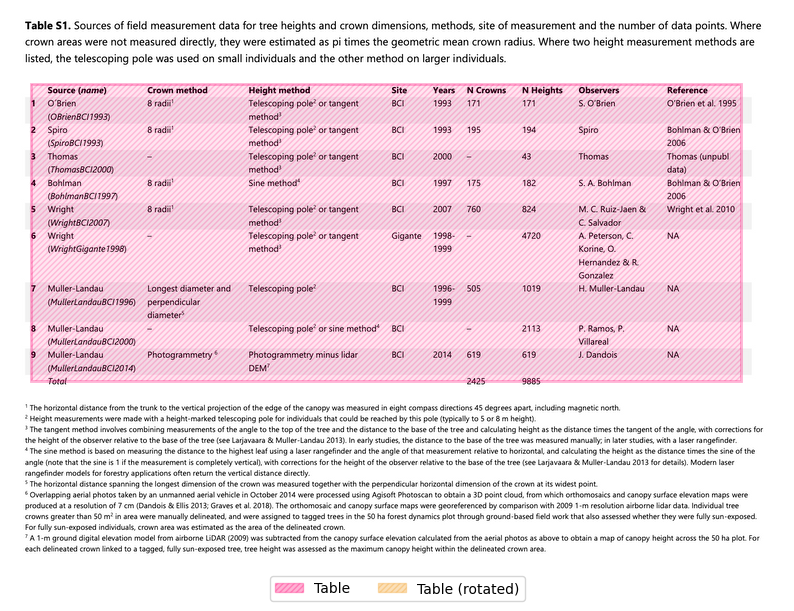

In [145]:
fig = visualize_detected_tables(image, objects)

In [146]:
visualized_image = fig2img(fig)

In [147]:
def objects_to_crops(img, tokens, objects, class_thresholds, padding=10):
    """
    Process the bounding boxes produced by the table detection model into
    cropped table images and cropped tokens.
    """

    table_crops = []
    for obj in objects:
        if obj['score'] < class_thresholds[obj['label']]:
            continue

        cropped_table = {}

        bbox = obj['bbox']
        bbox = [bbox[0]-padding, bbox[1]-padding, bbox[2]+padding, bbox[3]+padding]

        cropped_img = img.crop(bbox)

        table_tokens = [token for token in tokens if iob(token['bbox'], bbox) >= 0.5]
        for token in table_tokens:
            token['bbox'] = [token['bbox'][0]-bbox[0],
                             token['bbox'][1]-bbox[1],
                             token['bbox'][2]-bbox[0],
                             token['bbox'][3]-bbox[1]]

        # If table is predicted to be rotated, rotate cropped image and tokens/words:
        if obj['label'] == 'table rotated':
            cropped_img = cropped_img.rotate(270, expand=True)
            for token in table_tokens:
                bbox = token['bbox']
                bbox = [cropped_img.size[0]-bbox[3]-1,
                        bbox[0],
                        cropped_img.size[0]-bbox[1]-1,
                        bbox[2]]
                token['bbox'] = bbox

        cropped_table['image'] = cropped_img
        cropped_table['tokens'] = table_tokens
        table_crops.append(cropped_table)

    return table_crops

In [148]:
objects

[{'label': 'table',
  'score': 0.9999499320983887,
  'bbox': [47.15049743652344,
   164.14547729492188,
   1623.47802734375,
   825.27099609375]}]

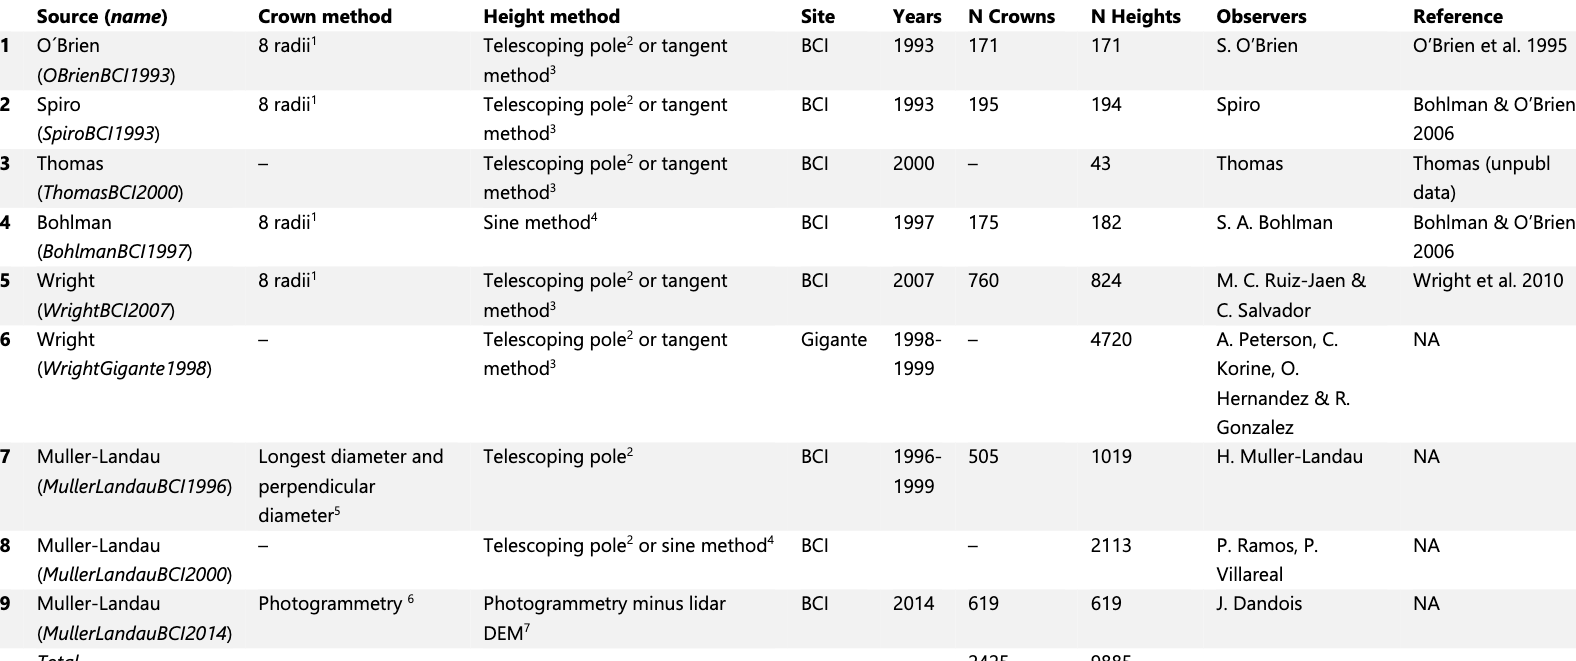

In [149]:
tokens = []
detection_class_thresholds = {
    "table": 0.5,
    "table rotated": 0.5,
    "no object": 10
}
crop_padding = 15

tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=0)
cropped_table = tables_crops[0]['image'].convert("RGB")
cropped_table

In [150]:
cropped_table.save("table.jpg")

## Load structure recognition model
### Next, we load a Table Transformer pre-trained for table structure recognition.

In [151]:
from transformers import TableTransformerForObjectDetection

# new v1.1 checkpoints require no timm anymore
"""structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)"""
structure_model = AutoModelForObjectDetection.from_pretrained(
    "microsoft/table-transformer-structure-recognition-v1.1-all"
).to(device).eval()
print("")

In [152]:
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
     

In [153]:

pixel_values = structure_transform(cropped_table).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 419, 1000])


In [154]:
with torch.no_grad():
  outputs = structure_model(pixel_values)

In [155]:
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)
print(cells)

[{'label': 'table spanning cell', 'score': 0.7609753012657166, 'bbox': [464.81866455078125, 441.778564453125, 775.999755859375, 534.2805786132812]}, {'label': 'table spanning cell', 'score': 0.5061187148094177, 'bbox': [949.4551391601562, 214.7813720703125, 1068.346435546875, 277.2195739746094]}, {'label': 'table spanning cell', 'score': 0.7469143271446228, 'bbox': [1392.8388671875, 441.9877624511719, 1575.203369140625, 533.0689697265625]}, {'label': 'table spanning cell', 'score': 0.553081214427948, 'bbox': [1.4698280096054077, 90.98356628417969, 27.91651725769043, 170.67063903808594]}, {'label': 'table column', 'score': 0.9998102784156799, 'bbox': [26.333948135375977, 3.8242318630218506, 248.08534240722656, 645.1094360351562]}, {'label': 'table spanning cell', 'score': 0.6851317286491394, 'bbox': [461.8666687011719, 314.1774597167969, 778.2584838867188, 445.9942932128906]}, {'label': 'table row', 'score': 0.9849606156349182, 'bbox': [0.5848512649536133, 145.95599365234375, 1574.47900

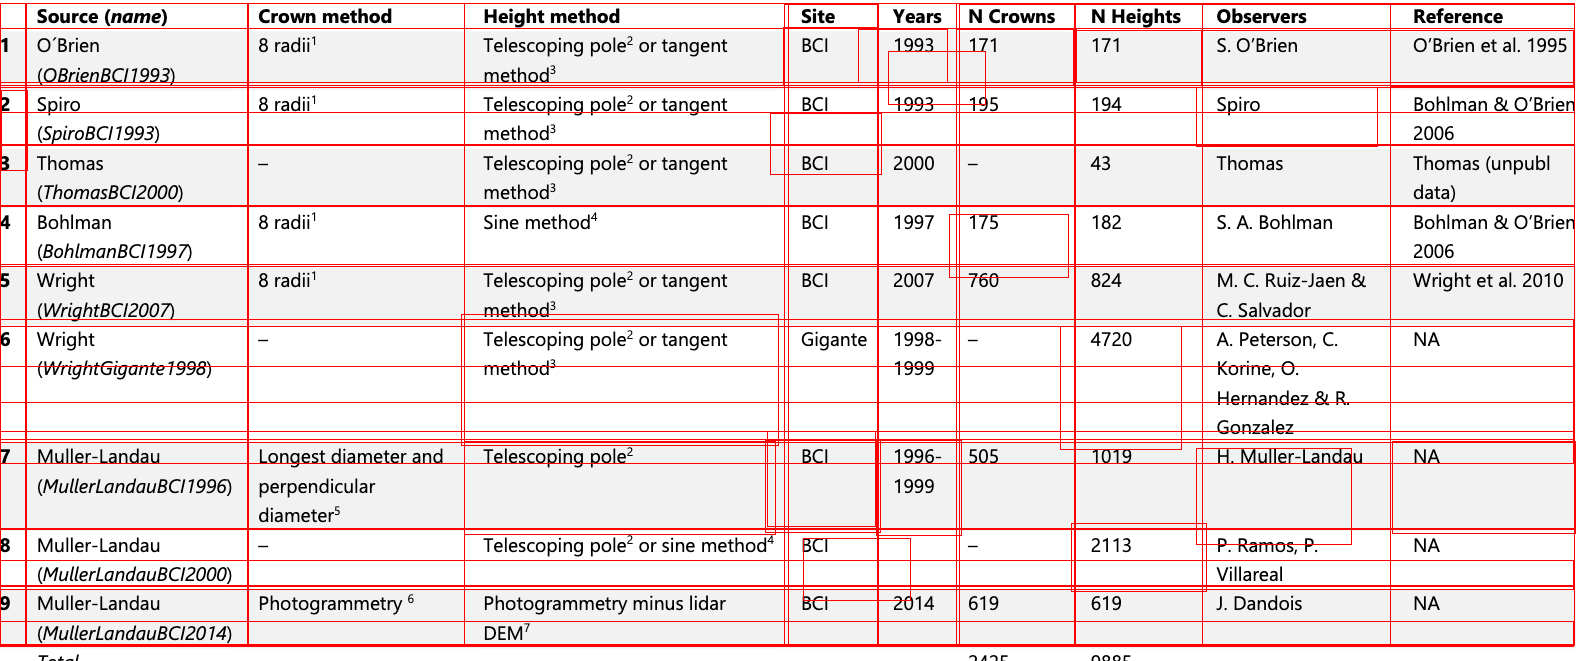

In [156]:
from PIL import ImageDraw

cropped_table_visualized = cropped_table.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")

cropped_table_visualized